### Primero importamos librerias y datos: 

In [1]:
from matplotlib import pyplot as mpl, cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os
os.getcwd()
raw_data = open('tp2_training_dataset.csv')
data = np.loadtxt(raw_data, delimiter=",")
data.shape

(900, 857)

## Reducción de dimensiones

Los 900 documentos pertenecen a 9 categorías distintas y disjuntas, además de que estan distribuidas uniformemente. 

Utilizaremos modelos de aprendizaje hebbiano no supervisado, para reducir las dimensiones de los vectores y lo haremos mediante la regla de aprendizaje de Oja y Sanger.

Llamaremos **x** a la matriz de dim = (900,856) y **z** a la categoría que corresponde cada documento. Normalizamos los datos de entrada considerando la desviación estándar del conjunto completo, para que el tipo de correlación no cambie. 

Así hacemos que la mayor dispersión de datos se encuentra en el origen y por lo tanto no condicionamos el entrenamiento con base en el desplazamiento en el espacio de los datos.Separamos
 las 900 instancias de datos en 675 de entrenamiento (aproximadamente 75%) y 225 de validación, aleatoriamente.

In [37]:
x = data[:,1:]
z = data[:,0]

x = (x-x.mean(axis=0)) / x.std()

P = np.shape(data)[0]
N = np.shape(data)[1] - 1
M = 9

p_corte = int(np.round(P*0.75))
indices = np.random.permutation(P)
trn = indices[:p_corte]
val = indices[p_corte:]

xtrn, ztrn = x[trn], z[trn]
xval, zval = x[val], z[val]

In [3]:
def Oja(X,Y,W): 
    Z = Y @ W.T
    return np.outer(X-Z,Y)

def Sanger(X,Y,W,M):
    D = np.triu(np.ones((M,M)))
    Z = np.dot(W, Y.T * D)
    return (X.T - Z) * Y

def f_ort(W,M): 
    return np.sum(np.abs(np.dot( W.T, W) - np.identity(M) ))/2

### Reduccion por regla de Oja: 

Usamos un coeficiente de aprendizaje inicial de **1*10^-5** y tolerancia de ortogonalidad **10^-5**, sabiendo que difícilmente llegue por la experimentación hecha. Inspirados en el método de aprendizaje competitivo usamos el decaimiento de lr (learning rate o coef de apredizaje) pero de una manera más simple. Probamos con **B = 45** y diferentes valores para el entrenamiento por lotes, pero no hubo ningún cambio significativo, por lo usamos el método hold-out clásico.

Realizamos **3000** iteraciones en el entrenamiento (épocas), observamos empíricamente que realizar más iteraciones no reduce el error de la ortogonalidad con los datos de entrenamiento, de igual manera no mejora los resultados al evaluar con los datos de validación. Pero con menos iteraciones obtuvimos peores resultados.

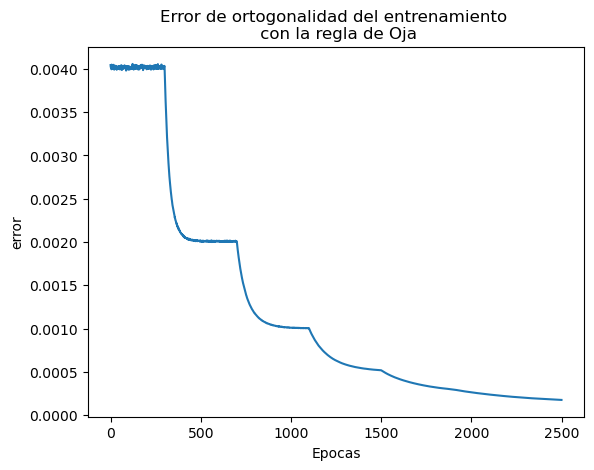

0.00017749888960713394


In [67]:
W_oja = np.random.normal(0,0.1,(N,M))
#B = 45
epoch = 0
ort = 1
lr = 1e-5
o_tol = 1e-7
epoch_max = 3000
E = []

while ort > o_tol and epoch < epoch_max :
    ort = 0
    if epoch % 400 == 0:
        lr /= 2
    stochastic = np.random.permutation(p_corte)
    for h in stochastic:
        #batch = stochastic[h:h+B]
        #for i in batch: 
        Xh = xtrn[h:h+1]
        Yh = Xh@W_oja 
        dW = Oja(Xh,Yh,W_oja)               
        W_oja += lr*dW
        ort += f_ort(W_oja, M)

    epoch += 1
    ort /= P
    E.append(ort)
mpl.plot(E[500:])
mpl.title('Error de ortogonalidad del entrenamiento \n con la regla de Oja')
mpl.xlabel('Epocas')
mpl.ylabel("error")
mpl.show()
print(E[len(E)-1])

In [85]:
validacion_oja = np.dot(xval, W_oja)
entrenado_oja = np.dot(xtrn, W_oja)

In [18]:
cmap = mpl.get_cmap("prism")
mpl.set_cmap(cmap)

<Figure size 640x480 with 0 Axes>

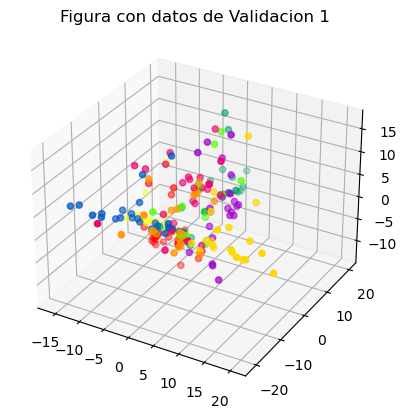

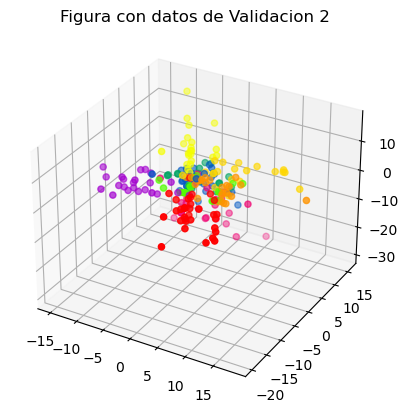

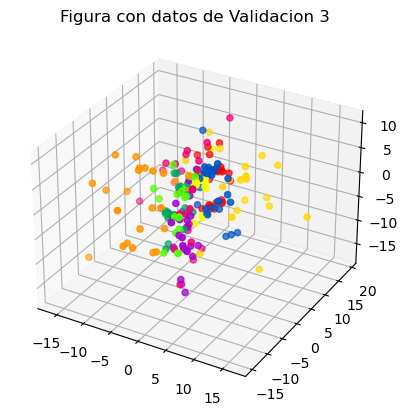

In [86]:
for i in range(3):     
    fig = mpl.figure()
    xyz = fig.add_subplot( 111, projection='3d')
    xyz.scatter3D(validacion_oja[:,i*3],validacion_oja[:,3*i+1],validacion_oja[:,3*i+2],c=zval.reshape(1,-1))
    mpl.title('Figura con datos de Validacion '+ str(i+1))
    #fig.show()

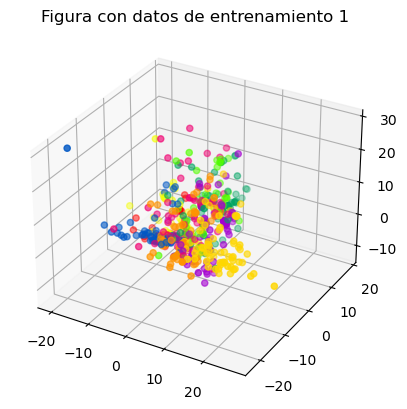

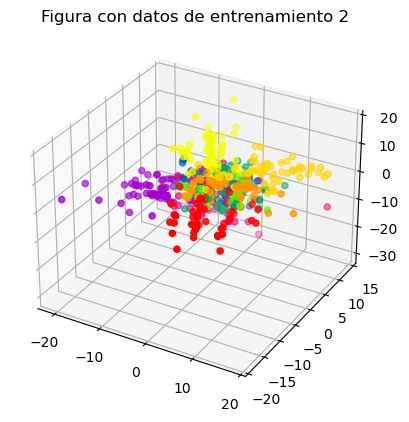

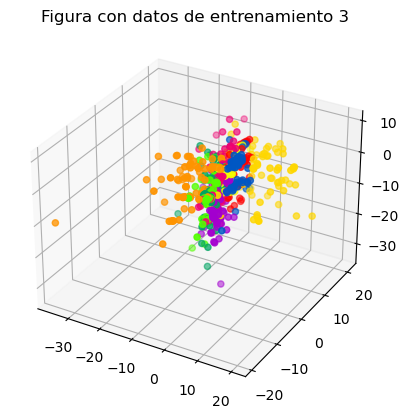

In [87]:
for i in range(3):     
    fig = mpl.figure()
    xyz = fig.add_subplot(111, projection='3d')
    xyz.scatter3D(entrenado_oja[:,i*3],entrenado_oja[:,3*i+1],entrenado_oja[:,3*i+2],c=ztrn.reshape(1,-1))
    mpl.title('Figura con datos de entrenamiento '+ str(i+1))
    #fig.show()

Observamos figuras poco alentadoras de que el entrenamiento haya sido exitoso, pues si bien se logra diferenciar las categorías, vemos que tanto en el caso de los datos de validación y entrenamiento en la figura 2 se observa una mayor separación de categorías con respecto a las otras 2 figuras.

### Reduccion por Regla Sanger

Análogamente que con la regla Oja, probamos con entrenamiento por lotes que terminamos desechando. 

3000 épocas, donde a conforme iterábamos decrecía el coef. de aprendizaje. 

Con lo previamente experimentado, en este punto solo hizo falta ajustar algunos parámetros.

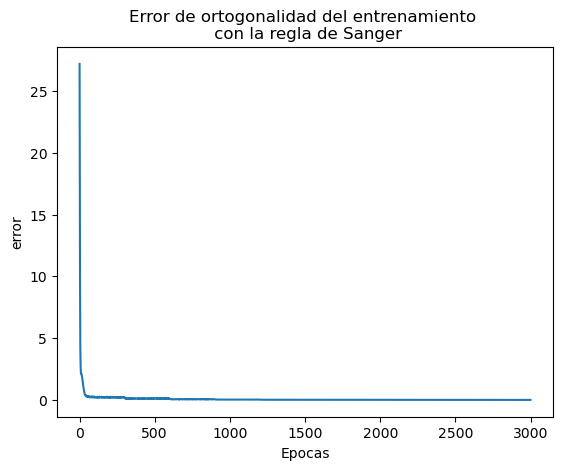

0.0008709554200187448


In [79]:
W_Sanger = np.random.normal(0,0.1,(N,M))
#B = 45
epoch = 0
ort = 1
lr = 5e-5
o_tol = 1e-5
epoch_max = 3000
E = []

while ort > o_tol and epoch < epoch_max :
    ort = 0
    if epoch % 300 == 0:
        lr /= 2
    stochastic = np.random.permutation(p_corte)
    for h in stochastic:
        #batch = stochastic[h:h+B]
        #for i in batch: 
        Xh = xtrn[h:h+1]
        Yh = Xh@W_Sanger 
        dW = Sanger(Xh, Yh, W_Sanger, M)      
        W_Sanger += lr*dW
        ort += f_ort(W_Sanger, M)

    epoch += 1
    ort /= P
    E.append(ort)
mpl.plot(E)
mpl.title('Error de ortogonalidad del entrenamiento \n con la regla de Sanger')
mpl.xlabel('Epocas')
mpl.ylabel("error")
mpl.show()
print(E[len(E)-1])

In [80]:
validacion_sanger = np.dot(xval, W_Sanger)
entrenado_sanger = np.dot(xtrn, W_Sanger)

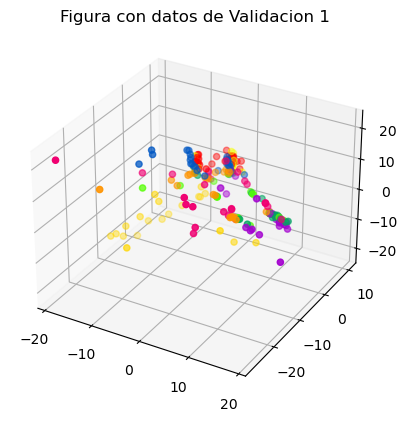

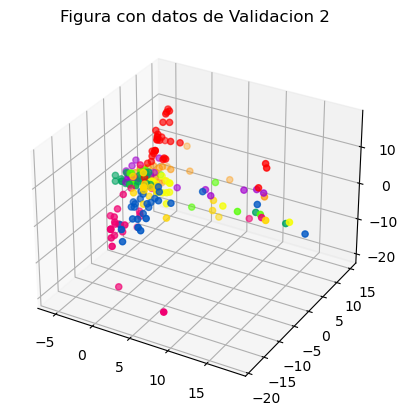

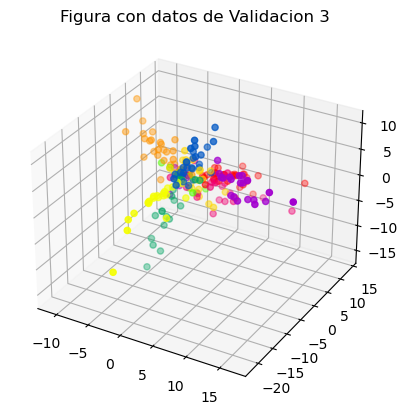

In [83]:
for i in range(3):     
    fig = mpl.figure()
    xyz = fig.add_subplot( 111, projection='3d')
    xyz.scatter3D(validacion_sanger[:,i*3],validacion_sanger[:,3*i+1],validacion_sanger[:,3*i+2],c = zval.reshape(1,-1))
    mpl.title('Figura con datos de Validacion '+ str(i+1))
    #fig.show()

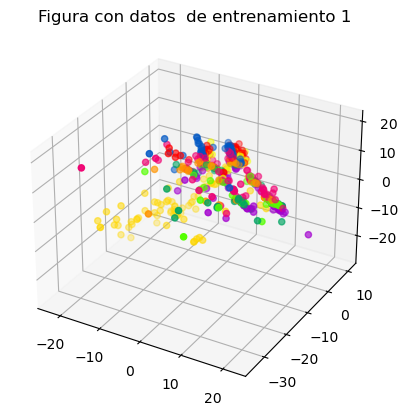

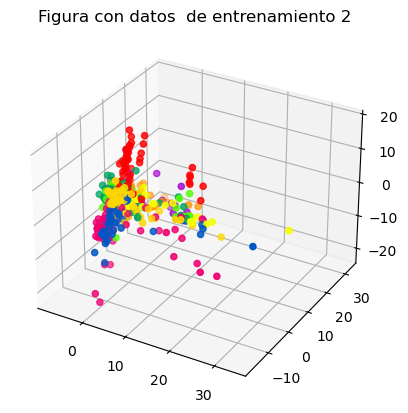

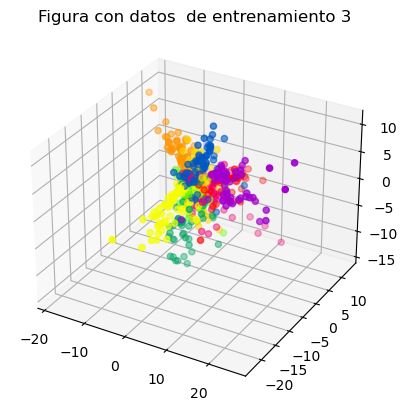

In [84]:
for i in range(3):     
    fig = mpl.figure()
    xyz = fig.add_subplot( 111, projection='3d')
    xyz.scatter3D(entrenado_sanger[:,i*3],entrenado_sanger[:,3*i+1],entrenado_sanger[:,3*i+2],c=ztrn.reshape(1,-1))
    mpl.title('Figura con datos  de entrenamiento '+ str(i+1))
    #fig.show()

En cambio en este caso observamos algo similar, pero con la figura 3, sin embargo en las demás figuras no consideró que haya un "abultamiento" más pronunciado que en caso de la regla de Oja.
Podemos concluir que el entrenamiento con la regla de Sanger resulta algo mejor, pero de todas formas no llega a cumplir significativamente una diferecia. 

Quizás esto se debe a que estamos haciendo una reducción de dimensión excesiva. Sumando a que con la regla de Sanger, obtenemos las primeras componentes principales, en cambio con la regla de Oja obtenemos el espacio generado por las mismas, talvez esto haga alguna diferencia en el entrenamiento pero no hay evidencias de nada.

### Mapeo de Características

Haremos un modelo basado en mapas auto-organizados(SOM) para ver si este puede auto-organizarse y así distinguir las distintas categorías.

Clasificara automáticamente los documentos en un arreglo de dos dimensiones.

Usaremos una grilla tamaño **15x15** pues nos ha parecido un tamaño adecuado y permitió una activación adecuada de las neuronas de salida. Para la salida se armó un mapa de características a partir de la activación de cada neurona en la grilla por cada instancia pasada.

Finalmente, para cada categoría a la que pertenece cada documento armamos un mapa específico de esta. Así poder ver cuáles zonas de la red activa una determinada categoría.

Optamos por los siguientes parametros para la parte de entrenamiento, usando la estrategia del radio de influencia  

Text(0.5, 1.0, 'Decaimiento de ir')

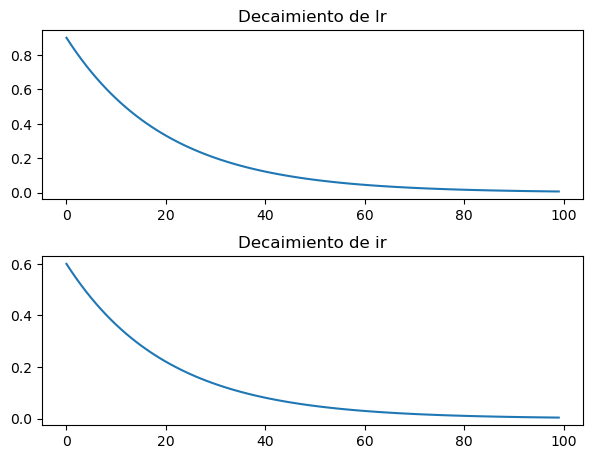

In [111]:
lr_st = 0.9  # tasa de inicial
lr_dr = 0.05  # tasa de decaimiento
ir_st = 0.6  # radio inicial
ir_dr = 0.05 # radio de decaimiento

t = np.arange(100)
lr = lr_st * np.exp(-t * lr_dr)
ir = ir_st * np.exp(-t * ir_dr)

fig, ax = mpl.subplots(2)
fig.tight_layout(pad=2.0)
ax[0].plot(t, lr)
ax[0].set_title("Decaimiento de lr")
ax[1].plot(t, ir)
ax[1].set_title("Decaimiento de ir")

Luego hicimos la implementacion del modelo

In [113]:
def SOM(instancia, w, M, epoch_max, lr_st, lr_dr, ir_st, ir_dr):
    N = len(instancia)
    il = [[(i, j) for j in range(M)] for i in range(M)] # creamos una matriz de coordenadas
    im = np.array(il) 
    
    Y = np.zeros((M, M)) 

    x = instancia.reshape(1,N) 

    for t in range(epoch_max):
        # activacion
        e = x - w
        err = np.linalg.norm(e, axis=2)

        pos = np.unravel_index(np.argmin(err), err.shape)

        Y.fill(0)  
        Y[pos] = 1

        # actualizamos los parametros: 
        
        lr = lr_st * np.exp(-t * lr_dr)  
        ir = ir_st * np.exp(-t * ir_dr)

        d = np.linalg.norm(im - pos, axis=2)

        # funcion de proximidad en cada epoca 
        pf = np.exp(-d / (2 * ir ** 2)).reshape((M, M, 1))
        dw = lr * pf * e
        w += dw
    
    return Y

In [125]:
M = 15 # tmb tamanio de salida
epoch_max = 100 # epocas 

# aplicamos el algoritmo SOM a cada instancia, para ello creamos array que contengan las grillas
mapas_SOM = [] 
mapas_categ = [] 

for i in range(9): 
      mapas_categ.append( np.zeros((M,M)) )

i = 0
w = np.random.normal(0, 0.1, (M,M,N))
for instancia in xtrn:
    mapa_som = SOM(instancia, w, M,epoch_max, lr_st, lr_dr, ir_st, ir_dr)
    mapas_SOM.append(mapa_som)
    j = int(ztrn[i])
    mapas_categ[j-1] = mapas_categ[j-1] + mapa_som
    i += 1

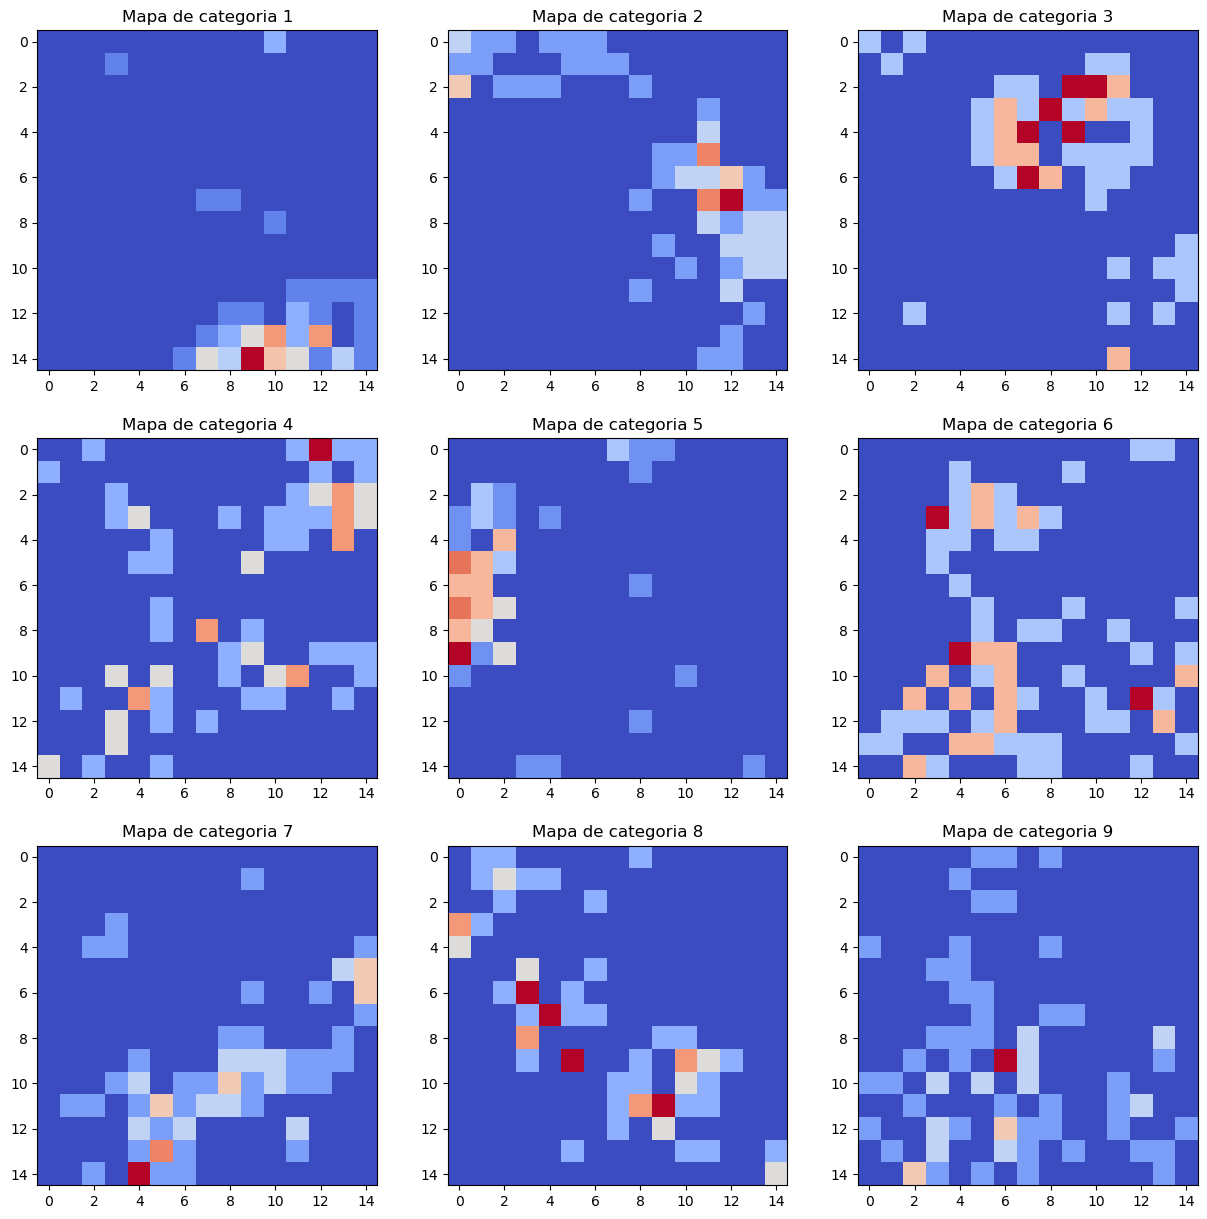

In [131]:
fig, axs = mpl.subplots(3,3, figsize = (M,M))
idx = 0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(mapas_categ[idx], cmap='coolwarm')
        axs[i,j].set_title( 'Mapa de categoria ' + str( idx + 1 ) )
        idx += 1

En el siguiente grafico podemos observar que no se observan una cantidad abrumadora de unidades "muertas" ya que durante el entrenamiento todas se activaron algunas veces, como minimo. Tambien podemos observar que esta activacion no fue uniforme sobre todas las instancias, quizas se deba a que haya grupos de instancias que presentan cierta correlacion y en consecuencia se terminen activando un sector particular de neuronas.  

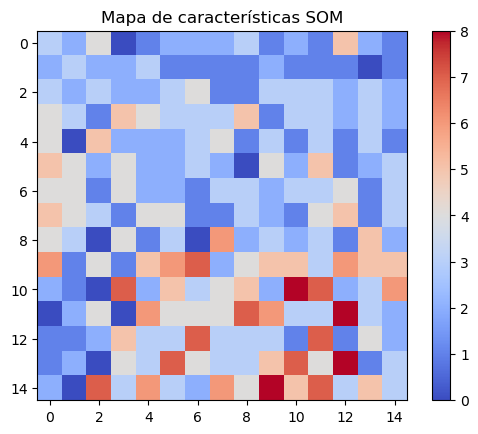

In [130]:
mapa_comb = np.sum(mapas_SOM, axis=0)
mpl.imshow(mapa_comb, cmap='coolwarm')
mpl.colorbar()
mpl.title("Mapa de características SOM")
mpl.show()

In [151]:
A = np.zeros((2,2))
A[0,0] = 1  
print(A.copy().astype(float))

[[1. 0.]
 [0. 0.]]


In [157]:
mapas_SOM_test = []
mapas_categ_test = []
for i in range(9): 
    mapas_categ_test.append( np.zeros((M,M)) )
i = 0

for inst_val in xval:     
    e = inst_val - w
    n = np.linalg.norm( e, axis=2)
    p = np.unravel_index( np.argmin(n), n.shape)
    y = np.zeros((M,M))
    y[p] = 1
    y_c = y.copy().astype(float)
    #mapas_SOM_test.append(y_c)
    j = int(zval[i])
    mapas_categ_test[j-1] = mapas_categ_test[j-1] + y_c
    #print(j)
    i += 1

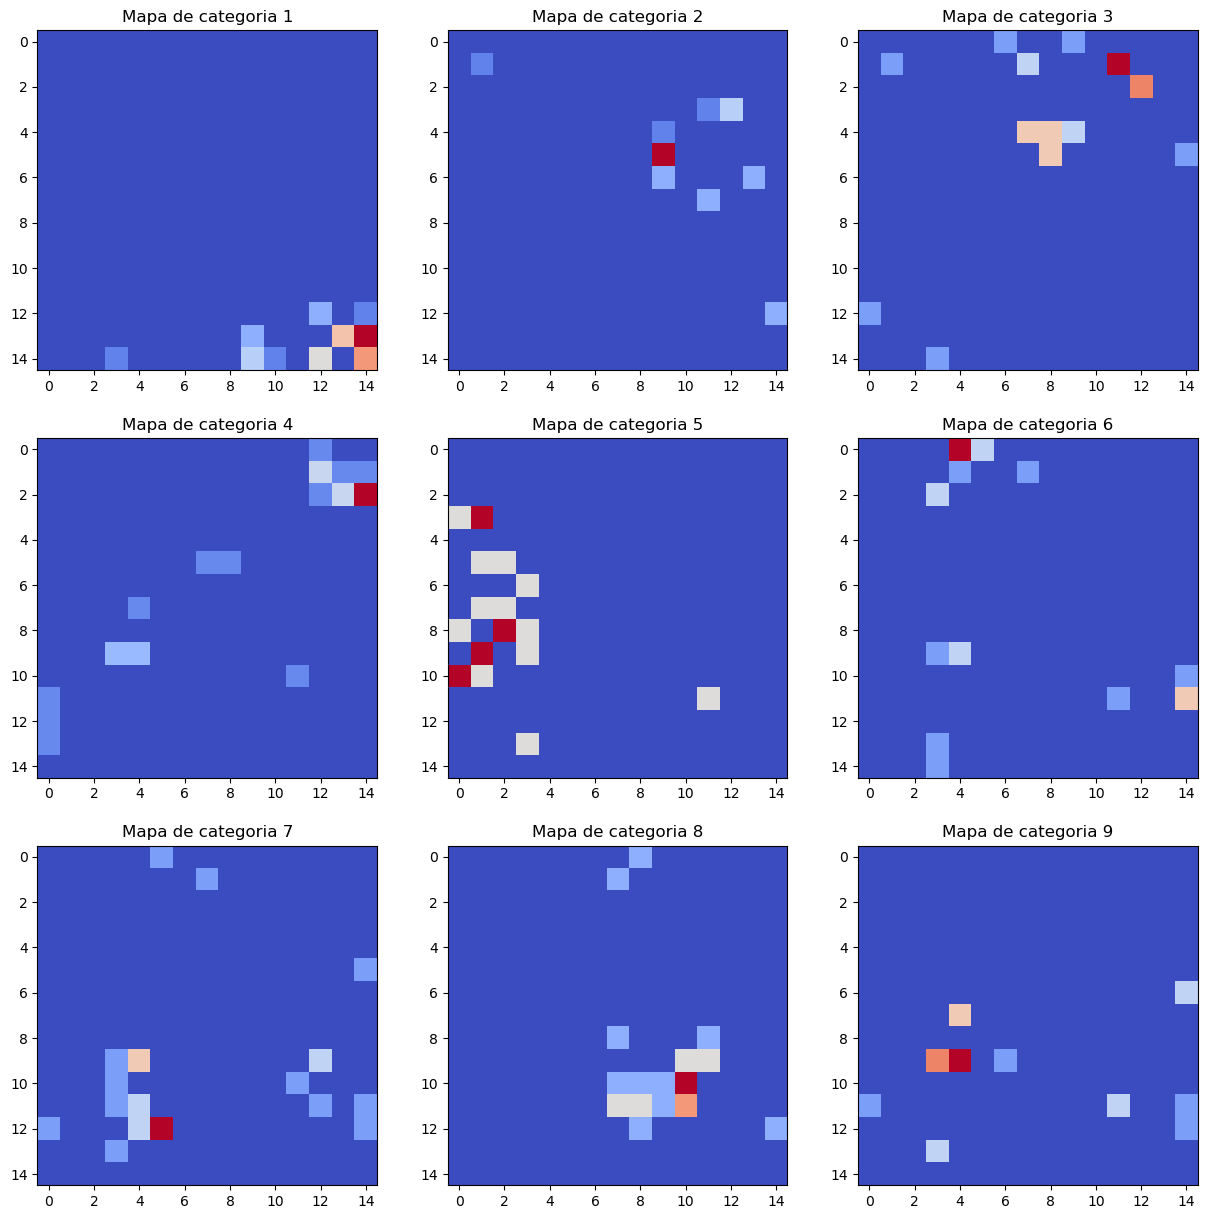

In [158]:
fig, axs = mpl.subplots(3,3, figsize = (M,M))
idx = 0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(mapas_categ_test[idx], cmap='coolwarm')
        axs[i,j].set_title( 'Mapa de categoria ' + str( idx + 1 ) )
        idx += 1

Podemos observar que con los datos de validación hay una cierta diferencia en cada categoría lo que hace que sean distinguibles, por lo que podemos decir que el entrenamiento fue aceptable.